In [351]:
#Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import requests
from bs4 import BeautifulSoup
%matplotlib inline

#Turn off chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [499]:
#Get the list of available movies and metadata from FML
r = requests.get("https://fantasymovieleague.com/researchvault?section=box-office")
soup = BeautifulSoup(r.content, 'lxml')

#Find the relevant table, clean it up
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]
df.drop(df.columns[0], axis=1, inplace=True) #The HTML table has an extra column of 1-indexed ranks
df.columns = df.columns.droplevel() #The HTML table has an erroneous multi-index

#Split name column to get FML price and name stored separately
df["price"] = df.iloc[:,0].str.split("$", n=0, expand=True)[1]
df["name"] = df.iloc[:,0].str.split("FB", n=0, expand=True)[0]
firststep = df.drop(df.columns[0], axis = 1) #Drop the old name column
firststep.head()

,Earnings,%Change,Earnings,%Change,Earnings,%Change,Earnings,%Change,price,name
0,$30.0M,-36.9%,$47.6M,-27.9%,$66.0M,-,-,-,351,SAT - Black Panther - SAT ONLY
1,$19.4M,-45.1%,$35.3M,-41.2%,$60.1M,-,-,-,263,SUN - Black Panther - SUN ONLY
2,$17.0M,-,-,-,-,-,-,-,176,Red Sparrow
3,$16.3M,-43.4%,$28.8M,-62.1%,$75.9M,-,-,-,205,FRI - Black Panther - FRI ONLY
4,$13.0M,-,-,-,-,-,-,-,167,Death Wish


In [500]:
#Deal with the special case of Blockbuster movies being split by day
firststep["day"] = 'ALL'
cleaned = firststep
days = ['FRI','SAT','SUN']

#If movie is split by day, store that row's day in "day" column
cleaned.loc[cleaned.name.str.contains('|'.join(days)),"day"] = cleaned[
    cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[0]

#If movie is split by day, store that row's cleaned name in "name" column
cleaned.loc[cleaned.name.str.contains('|'.join(days)),"name"] = cleaned[
    cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[1]

#Rename columns, drop irrelevant columns
cleaned.columns.values[[0,2,4,6]] = ["lastweek","2weeksago","3weeksago","4weeksago"]
final = cleaned.drop(cleaned.columns[[1,3,5,7]], axis = 1)
final

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day
0,$30.0M,$47.6M,$66.0M,-,351,Black Panther,SAT
1,$19.4M,$35.3M,$60.1M,-,263,Black Panther,SUN
2,$17.0M,-,-,-,176,Red Sparrow,ALL
3,$16.3M,$28.8M,$75.9M,-,205,Black Panther,FRI
4,$13.0M,-,-,-,167,Death Wish,ALL
5,$10.7M,$17.0M,-,-,97,Game Night,ALL
6,$10.0M,$12.8M,$23.4M,$25.0M,94,Peter Rabbit,ALL
7,$5.7M,$11.1M,-,-,53,Annihilation,ALL
8,$4.5M,$5.7M,$10.0M,$10.0M,42,Jumanji: Welcome to the Jungle,ALL
9,$3.3M,$7.1M,$19.4M,$38.6M,30,Fifty Shades Freed,ALL


In [501]:
#Before getting daily numbers from the-numbers.com, we need movie names in the format the-numbers uses for URLs.
#Luckily, the-numbers.com has consistent URL conventions!

final["url_part"] = final["name"]

the_mask = final["url_part"].str.startswith("The ")
final.loc[the_mask, "url_part"] = final.loc[the_mask, "url_part"].str.replace("The ","") + " The" #Move "The" to end
final["url_part"] = final["url_part"].str.replace(' ', '-')

#colons with a space after are removed (as in "Jumani: ")
final["url_part"] = final["url_part"].str.replace(': |,|\'|!','')
#colons within words or numbers (as in "15:17") are replaced with dashes
final["url_part"] = final["url_part"].str.replace(':', '-')
final

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day,url_part
0,$30.0M,$47.6M,$66.0M,-,351,Black Panther,SAT,Black-Panther
1,$19.4M,$35.3M,$60.1M,-,263,Black Panther,SUN,Black-Panther
2,$17.0M,-,-,-,176,Red Sparrow,ALL,Red-Sparrow
3,$16.3M,$28.8M,$75.9M,-,205,Black Panther,FRI,Black-Panther
4,$13.0M,-,-,-,167,Death Wish,ALL,Death-Wish
5,$10.7M,$17.0M,-,-,97,Game Night,ALL,Game-Night
6,$10.0M,$12.8M,$23.4M,$25.0M,94,Peter Rabbit,ALL,Peter-Rabbit
7,$5.7M,$11.1M,-,-,53,Annihilation,ALL,Annihilation
8,$4.5M,$5.7M,$10.0M,$10.0M,42,Jumanji: Welcome to the Jungle,ALL,Jumanji--Welcome-to-the-Jungle
9,$3.3M,$7.1M,$19.4M,$38.6M,30,Fifty Shades Freed,ALL,Fifty-Shades-Freed


In [502]:
#This function takes in one of the cleaned URL_parts we made above and grabs the associated data from the-numbers.com

def get_table(row):
    try:
        r = requests.get("https://www.the-numbers.com/movie/{}".format(row))
        soup = BeautifulSoup(r.content, 'lxml')
        table = soup.find_all(id = 'box_office_chart')[1]   
        movie = pd.read_html(str(table))[0]
        movie.columns = movie.iloc[0]
        movie = movie[1:]
        movie["Gross"] = movie["Gross"].str.replace('\$|,','')
        print("Found and stored data for {}!".format(row))
        return movie
    except IndexError: #the-numbers.com sometimes includes movie year, sometimes does not
        print("No luck finding {}, will try adding -(2018)".format(row))
        try:
            r = requests.get("https://www.the-numbers.com/movie/{}-(2018)".format(row))
            soup = BeautifulSoup(r.content, 'lxml')
            table = soup.find_all(id = 'box_office_chart')[1]   
            movie = pd.read_html(str(table))[0]
            movie.columns = movie.iloc[0]
            movie = movie[1:]
            movie["Gross"] = movie["Gross"].str.replace('\$|,','')
            print("Found and stored data for {}!".format(row))
            return movie
        except IndexError: #the-numbers.com mislabeled "Death With" as from 2017...
            print("No luck finding {}-(2018) either. Will try adding -(2017)".format(row))
            try:
                r = requests.get("https://www.the-numbers.com/movie/{}-(2017)".format(row))
                soup = BeautifulSoup(r.content, 'lxml')
                table = soup.find_all(id = 'box_office_chart')[1]   
                movie = pd.read_html(str(table))[0]
                movie.columns = movie.iloc[0]
                movie = movie[1:]
                movie["Gross"] = movie["Gross"].str.replace('\$|,','')
                print("Found and stored data for {}!".format(row))
                print(movie)
                return movie
            except IndexError:
                print("Looks like {} doesn't exist on the-numbers.com. Try a google search?".format(row))

In [503]:
#Incredibly, the forecast part is one of the easiest.

def forecast(df):
    #fbprophet requires one "y" column for values and one "ds" column for dates
    df["y"] = pd.to_numeric(df["Gross"])
    df["ds"] = pd.to_datetime(df["Date"], format = '%Y/%m/%d')
    m = Prophet(changepoint_prior_scale=.5) #default 0.05, this makes the trend fit more flexible
    m.fit(df)
    future_data = m.make_future_dataframe(periods=7) #forecast a week to make sure we capture next week's numbers
    forecast_data = m.predict(future_data)
    m.plot(forecast_data)
    plt.title(row)
    plt.show()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


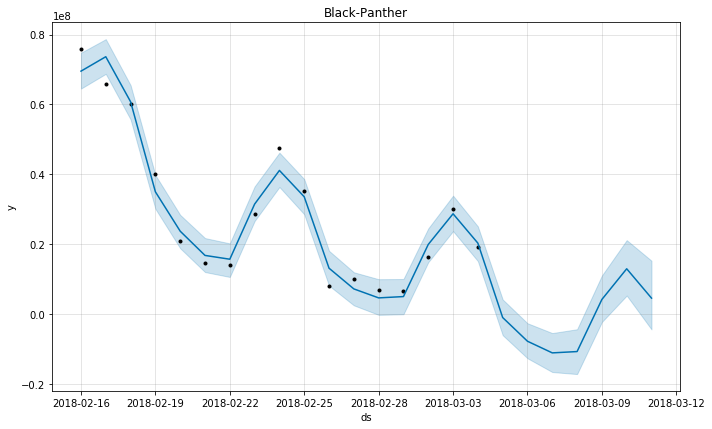

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


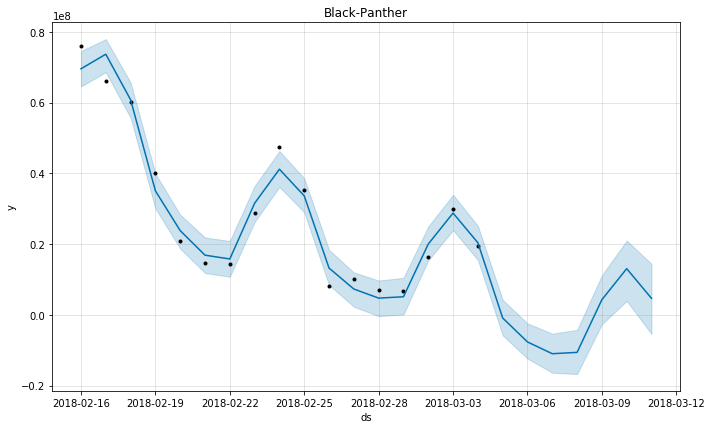

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Red-Sparrow!


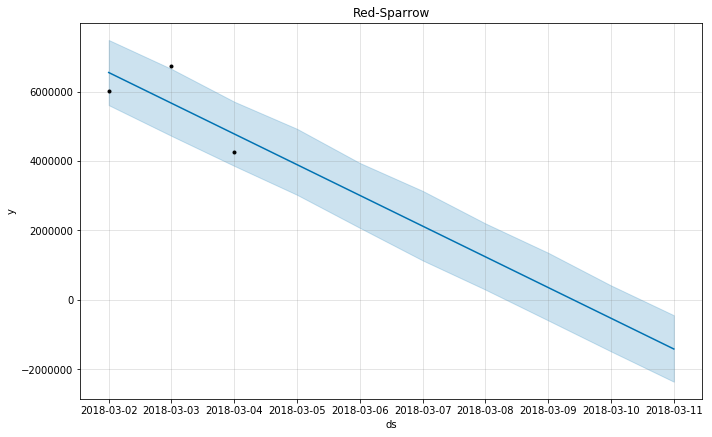

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


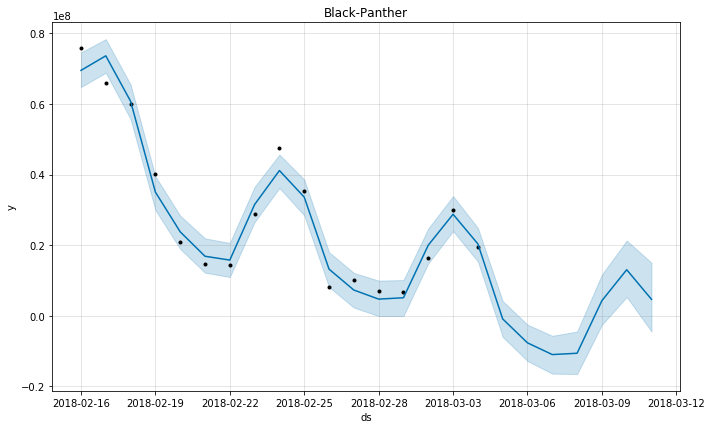

No luck finding Death-Wish, will try adding -(2018)
No luck finding Death-Wish-(2018) either. Will try adding -(2017)


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Death-Wish!
0        Date Rank    Gross % Change Theaters Per Theater  Total Gross Days
1  2018/03/02    3  4275000      NaN     2847      $1,502   $4,275,000    1
2  2018/03/03    3  5240000     +23%     2847      $1,841   $9,515,000    2
3  2018/03/04    3  3510000     -33%     2847      $1,233  $13,025,000    3


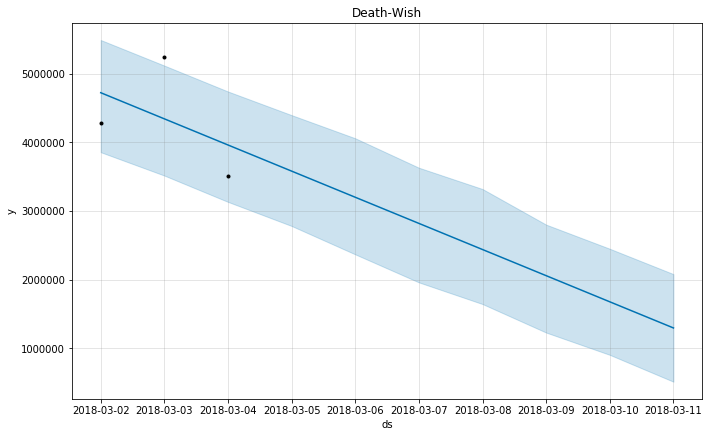

No luck finding Game-Night, will try adding -(2018)


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.


Found and stored data for Game-Night!


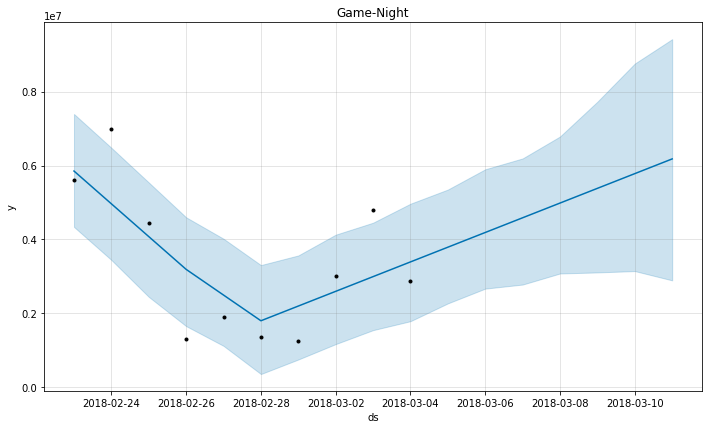

No luck finding Peter-Rabbit, will try adding -(2018)


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for Peter-Rabbit!


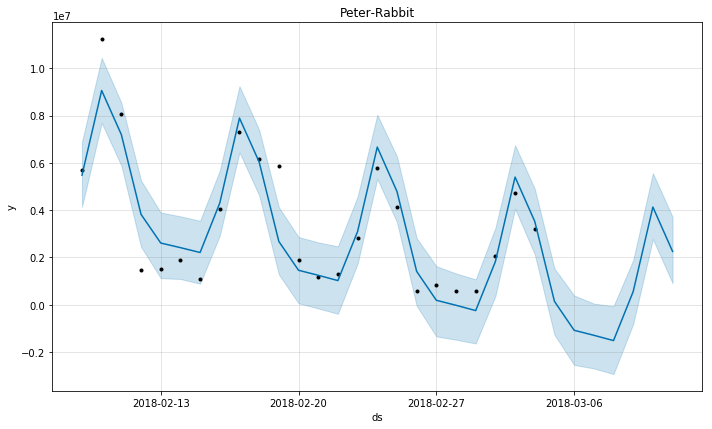

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.


Found and stored data for Annihilation!


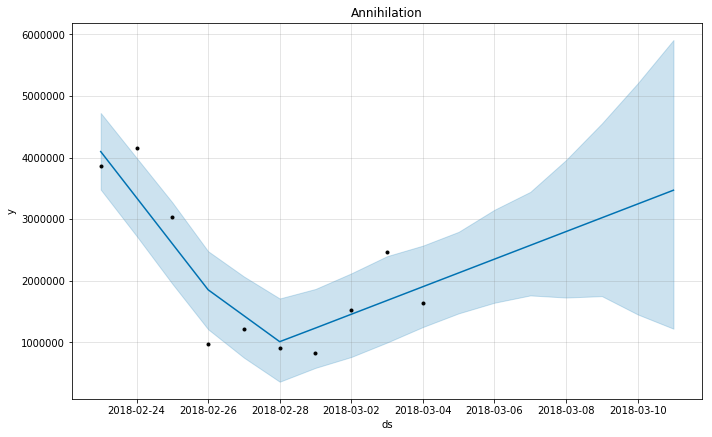

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Jumanji--Welcome-to-the-Jungle!


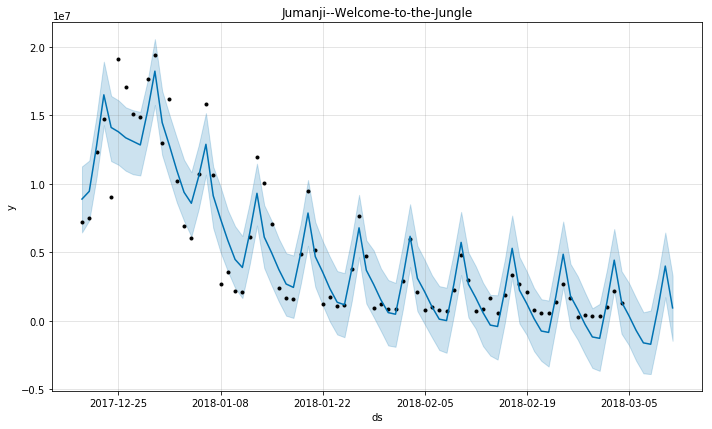

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for Fifty-Shades-Freed!


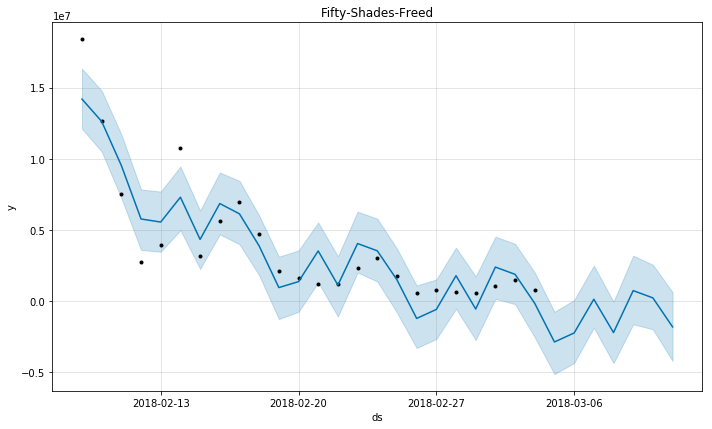

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Greatest-Showman-The!


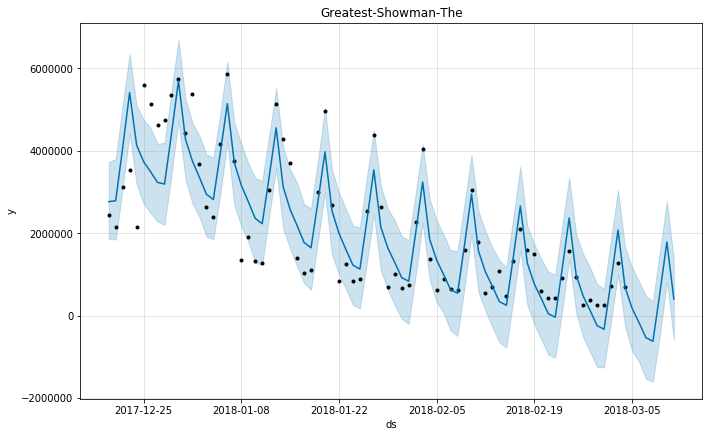

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Every-Day!


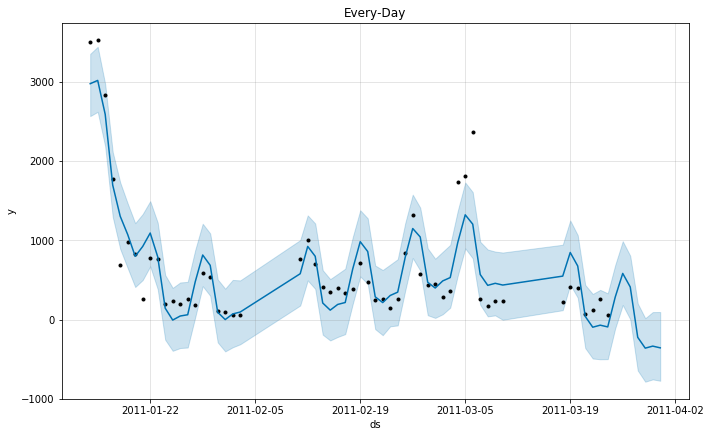

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for 15-17-to-Paris-The!


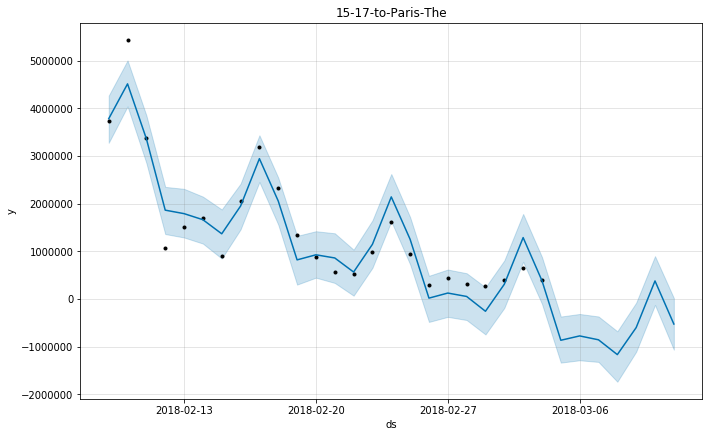

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Shape-of-Water-The!


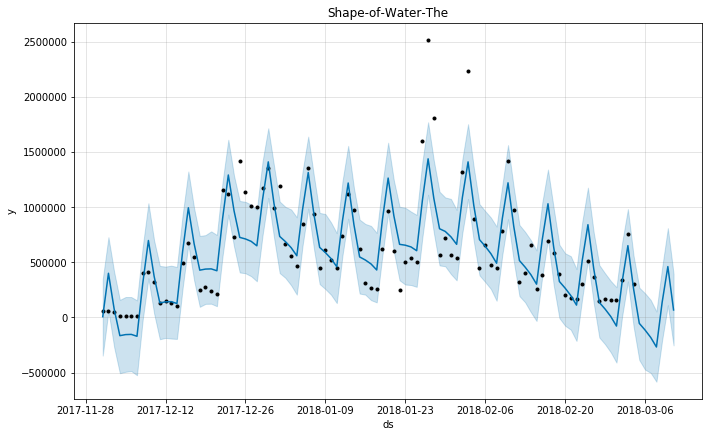

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Three-Billboards-Outside-Ebbing-Missouri!


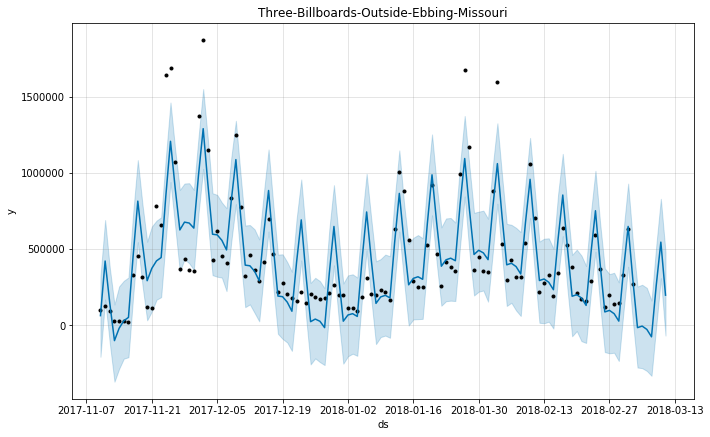

In [504]:
for row in final["url_part"]:
    movie = get_table(row)
    forecast(movie)

In [347]:
for row in final["url_part"]:
    try:
        r = requests.get("https://www.the-numbers.com/movie/{}".format(row))
        soup = BeautifulSoup(r.content, 'lxml')
        table = soup.find_all(id = 'box_office_chart')[1]   
        movie = pd.read_html(str(table))[0]
        movie.columns = movie.iloc[0]
        movie = movie[1:]
        print("Found and stored data for {}!".format(row))
    except IndexError:
        print("No luck finding {}, will try adding -(2018)".format(row))
        try:
            r = requests.get("https://www.the-numbers.com/movie/{}-(2018)".format(row))
            soup = BeautifulSoup(r.content, 'lxml')
            table = soup.find_all(id = 'box_office_chart')[1]   
            movie = pd.read_html(str(table))[0]
            movie.columns = movie.iloc[0]
            movie = movie[1:]
            print("Found and stored data for {}!".format(row))
        except IndexError:
            print("No luck finding {}-(2017) either. Will try adding -(2017)".format(row))
            try:
                r = requests.get("https://www.the-numbers.com/movie/{}-(2017)".format(row))
                soup = BeautifulSoup(r.content, 'lxml')
                table = soup.find_all(id = 'box_office_chart')[1]   
                movie = pd.read_html(str(table))[0]
                movie.columns = movie.iloc[0]
                movie = movie[1:]
                print("Found and stored data for {}!".format(row))
            except IndexError:
                print("Looks like {} doesn't exist on the-numbers.com. Try a google search?".format(row))

Found and stored data for Black-Panther!
Found and stored data for Black-Panther!
Found and stored data for Red-Sparrow!
Found and stored data for Black-Panther!
No luck finding Death-Wish, will try adding -(2018)
No luck finding Death-Wish-(2017) either. Will try adding -(2017)
Found and stored data for Death-Wish!
No luck finding Game-Night, will try adding -(2018)
Found and stored data for Game-Night!
No luck finding Peter-Rabbit, will try adding -(2018)
Found and stored data for Peter-Rabbit!
Found and stored data for Annihilation!
Found and stored data for Jumanji--Welcome-to-the-Jungle!
Found and stored data for Fifty-Shades-Freed!
Found and stored data for Greatest-Showman-The!
Found and stored data for 15-17-to-Paris-The!
Found and stored data for Every-Day!
Found and stored data for Shape-of-Water-The!
Found and stored data for Three-Billboards-Outside-Ebbing-Missouri!


In [348]:
r = requests.get("https://www.the-numbers.com/movie/Death-Wish")
soup = BeautifulSoup(r.content, 'lxml')
table = soup.find_all(id = 'box_office_chart')
print(table)
movie = pd.read_html(str(table))[0]
movie.columns = movie.iloc[0]
movie = movie[1:]

[]


ValueError: No tables found

In [326]:
row = "Black-Panther"
r = requests.get("https://www.the-numbers.com/movie/{}".format(row))
soup = BeautifulSoup(r.content, 'lxml')
table = soup.find_all(id = 'box_office_chart')[1]   
movie = pd.read_html(str(table))[0]
movie.columns = movie.iloc[0]
movie = movie[1:]
#data = pd.read_html(str(table))[0]
#data.drop(data.columns[0], axis=1, inplace=True)
#data.columns = data.columns.droplevel()
movie.head()

,Date,Rank,Gross,% Change,Theaters,Per Theater,Total Gross,Days
1,2018/02/16,1,"$75,941,146",NaN,4020,"$18,891","$75,941,146",1
2,2018/02/17,1,"$65,995,366",-13%,4020,"$16,417","$141,936,512",2
3,2018/02/18,1,"$60,067,439",-9%,4020,"$14,942","$202,003,951",3
4,2018/02/19,1,"$40,151,729",-33%,4020,"$9,988","$242,155,680",4
5,2018/02/20,1,"$20,857,361",-48%,4020,"$5,188","$263,013,041",5


In [453]:
help(Prophet.fit)

Help on function fit in module fbprophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.
    
    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.
    
    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.
    
    Returns
    -------
    The fitted Prophet objec